# Step #1 Initialize Spark and Load the Data

In [1]:
# A tutorial for this file is available at www.relately.com

# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, DateType
from pyspark.sql.functions import col, sum, udf, year, month, to_timestamp, to_date
import pyspark.sql.functions as f
import seaborn as sns
import matplotlib.pyplot as plt

# Create my_spark
spark = SparkSession.builder.getOrCreate()
print(spark)

base_path = "data"

# read weather data from a .csv file - schema infered 
# https://www.kaggle.com/sobhanmoosavi/us-weather-events
# This is a countrywide weather events dataset that includes 7.5 million events, and covers 49 states of the United States. 
# Examples of weather events are rain, snow, storm, and freezing condition. Some of the events in this dataset are extreme events (e.g. storm) and some could be regarded as regular events (e.g. rain and snow). 
# The data is collected from January 2016 to December 2021, using historical weather reports that were collected from 2,071 airport-based weather stations across the nation. 


spark_weather_df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv(path=f'{base_path}/weather/frankfurt_weather')
    #.csv(path=f'{base_path}/weather/US/weather_events_us_2016-2021.csv')
spark_weather_df.show(3, truncate = False)
spark_weather_df.printSchema()
spark_weather_df.count()

AnalysisException: Path does not exist: file:/c:/Users/Flo/workspace/relataly-public-python-tutorials/data/weather/frankfurt_weather

In [3]:
# read US city zip codes from a .json file https://worldpopulationreview.com/zips

# Define a Custom Schema
# Note: we could also infer the schema with .option("inferSchema", True)
schema = StructType(fields=[StructField("zip", IntegerType(), True),
                             StructField("city", StringType(), True),
                             StructField("county", StringType(), True),
                             StructField("pop", IntegerType(), True)])

spark_city_df = spark.read \
    .schema(schema) \
    .option("multiline","true")\
    .json(path=f'{base_path}/cities/uszipdata.json')
    
spark_city_df = spark_city_df.select("*").withColumnRenamed("city", "city2") 
spark_city_df.printSchema()
spark_city_df.show(3)


root
 |-- zip: integer (nullable = true)
 |-- city2: string (nullable = true)
 |-- county: string (nullable = true)
 |-- pop: integer (nullable = true)

+-----+------+---------+------+
|  zip| city2|   county|   pop|
+-----+------+---------+------+
|77449|  Katy|   Harris|128294|
|77494|  Katy|Fort Bend|118291|
|11368|Corona|   Queens|112088|
+-----+------+---------+------+
only showing top 3 rows



# Step #2 Join and Transform the Data using Standard PySpark Functions

In [4]:

# We only want weather data for 

spark_df = spark_weather_df \
.join(spark_city_df, spark_weather_df.ZipCode == spark_city_df.zip,how="inner") 
spark_df.show(3)
spark_df.count()

+--------+----+--------+-------------------+-------------------+-----------------+----------+-----------+-----------+-----------+--------+--------+-----+-------+----+--------+--------+-----+
| EventId|Type|Severity|     StartTime(UTC)|       EndTime(UTC)|Precipitation(in)|  TimeZone|AirportCode|LocationLat|LocationLng|    City|  County|State|ZipCode| zip|   city2|  county|  pop|
+--------+----+--------+-------------------+-------------------+-----------------+----------+-----------+-----------+-----------+--------+--------+-----+-------+----+--------+--------+-----+
|W-523186|Snow|   Light|2016-01-02 00:52:00|2016-01-02 01:52:00|              0.0|US/Eastern|       KPYM|    41.9085|   -70.7279|Plymouth|Plymouth|   MA|   2360|2360|Plymouth|Plymouth|59826|
|W-523187|Snow|   Light|2016-01-04 17:52:00|2016-01-05 17:52:00|              0.0|US/Eastern|       KPYM|    41.9085|   -70.7279|Plymouth|Plymouth|   MA|   2360|2360|Plymouth|Plymouth|59826|
|W-523188| Fog|  Severe|2016-01-10 07:07:00|2

141729

In [5]:
spark_df2  = spark_df\
.withColumnRenamed("pop", "population") \
.withColumnRenamed("StartTime(UTC)", "StartDateTime") \
.withColumnRenamed("EndTime(UTC)", "EndDateTime") \
.withColumnRenamed("Precipitation(in)", "Precipitation") \
.withColumn("StartDateTime", to_timestamp(col("StartDateTime"),"yyyy-MM-dd HH:mm:ss")) \
.withColumn("StartDate", to_date(col("StartDateTime"),"yyyy-MM-dd HH:mm:ss")) \
.withColumn("StartYear", year(to_timestamp(col("StartDateTime"),"yyyy-MM-dd HH:mm:ss"))) \
.withColumn("StartMonth", month(to_timestamp(col("StartDateTime"),"yyyy-MM-dd HH:mm:ss"))) \
.withColumn("EventDuration", (to_timestamp(col("EndDateTime"),"yyyy-MM-dd HH:mm:ss").cast("long") - to_timestamp(col("StartDateTime"),"yyyy-MM-dd HH:mm:ss").cast("long"))/60) \
.drop("zip", "county", "city2", "AirportCode", "TimeZone", "EventId", "EndDateTime")

spark_df2.show(3)   


+----+--------+-------------------+-------------+-----------+-----------+--------+-----+-------+----------+----------+---------+----------+-------------+
|Type|Severity|      StartDateTime|Precipitation|LocationLat|LocationLng|    City|State|ZipCode|population| StartDate|StartYear|StartMonth|EventDuration|
+----+--------+-------------------+-------------+-----------+-----------+--------+-----+-------+----------+----------+---------+----------+-------------+
|Snow|   Light|2016-01-02 00:52:00|          0.0|    41.9085|   -70.7279|Plymouth|   MA|   2360|     59826|2016-01-02|     2016|         1|         60.0|
|Snow|   Light|2016-01-04 17:52:00|          0.0|    41.9085|   -70.7279|Plymouth|   MA|   2360|     59826|2016-01-04|     2016|         1|       1440.0|
| Fog|  Severe|2016-01-10 07:07:00|          0.0|    41.9085|   -70.7279|Plymouth|   MA|   2360|     59826|2016-01-10|     2016|         1|        258.0|
+----+--------+-------------------+-------------+-----------+-----------+---

In [6]:
# Replace UNK with NA
num_dict = {'UNK':"NA"} # To change multiple values, do something like: {'Other':"-1",'Light':"0",'Moderate':"1", 'Severe':"2", 'Heavy':"3", 'UNK':"4"}
spark_df2 = spark_df2.replace(num_dict, subset=['Severity'])
spark_df2.show(3)

+----+--------+-------------------+-------------+-----------+-----------+--------+-----+-------+----------+----------+---------+----------+-------------+
|Type|Severity|      StartDateTime|Precipitation|LocationLat|LocationLng|    City|State|ZipCode|population| StartDate|StartYear|StartMonth|EventDuration|
+----+--------+-------------------+-------------+-----------+-----------+--------+-----+-------+----------+----------+---------+----------+-------------+
|Snow|   Light|2016-01-02 00:52:00|          0.0|    41.9085|   -70.7279|Plymouth|   MA|   2360|     59826|2016-01-02|     2016|         1|         60.0|
|Snow|   Light|2016-01-04 17:52:00|          0.0|    41.9085|   -70.7279|Plymouth|   MA|   2360|     59826|2016-01-04|     2016|         1|       1440.0|
| Fog|  Severe|2016-01-10 07:07:00|          0.0|    41.9085|   -70.7279|Plymouth|   MA|   2360|     59826|2016-01-10|     2016|         1|        258.0|
+----+--------+-------------------+-------------+-----------+-----------+---

# Step #3 Simple Example for a User Defined Function Example

In [7]:
# print some statistics on the distribution of Precipitation
spark_df2.select("Precipitation").describe().show()
# Alternatively to get the max value, we could use max_value = spark_df2.agg({"Precipitation": "max"}).collect()[0][0]

+-------+-------------------+
|summary|      Precipitation|
+-------+-------------------+
|  count|             141729|
|   mean|0.10370799201292495|
| stddev|  0.509839403671497|
|    min|                0.0|
|    max|              30.08|
+-------+-------------------+



In [8]:
# More Infos on User Defined Functions: https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/

# Define a custom python function that adds an additional Event Type for Events where Precipitation was more than 10 in
def convertCase(type, preci):
    if (type == "Rain") and (preci > 10):
        return "Heavy_Rain"
    return "Rain"

# Converting the custom python function to UDF
caseUDF = udf(lambda x, y: convertCase(x,y),StringType())

# Applying the UDF to a column of our dataframe
spark_df2 = spark_df2.withColumn("Type2", caseUDF(col("Type"), col("Precipitation")).alias("Type2"))

# Print the result
spark_df2.select("*").filter(col("Type2") == "Heavy_Rain").show(3)

+----+--------+-------------------+-------------+-----------+-----------+--------------------+-----+-------+----------+----------+---------+----------+-------------+----------+
|Type|Severity|      StartDateTime|Precipitation|LocationLat|LocationLng|                City|State|ZipCode|population| StartDate|StartYear|StartMonth|EventDuration|     Type2|
+----+--------+-------------------+-------------+-----------+-----------+--------------------+-----+-------+----------+----------+---------+----------+-------------+----------+
|Rain|   Heavy|2017-05-22 00:17:00|        11.72|    29.7086|   -98.0453|       New Braunfels|   TX|  78130|     77400|2017-05-22|     2017|         5|         42.0|Heavy_Rain|
|Rain|   Heavy|2017-08-28 21:21:00|        18.93|    25.9995|   -80.2412|Miramar-Pembroke ...|   FL|  33023|     73973|2017-08-28|     2017|         8|        105.0|Heavy_Rain|
|Rain|   Heavy|2016-08-03 00:06:00|        12.04|    25.6423|   -80.4347|               Miami|   FL|  33186|     68

# Step #4 Data Analysis using Standard PySpark Functions

In [24]:
# check for null values
dfnull = spark_df2.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in spark_df2.columns))
dfnull.show()

# check for dublicate values
spark_df2.groupBy(spark_df2.columns)\
    .count()\
    .where(f.col('count') > 1)\
    .select(f.sum('count').alias("Dublicates"))\
    .show()

# print distinct values
spark_df.select(["Type", "Severity"]).distinct().show()

# filter the data
spark_df2_filter = spark_df2.filter(spark_df2.Severity.isin(["Other", "NA"]) == False).filter(spark_df2.Precipitation > 0)

+----+--------+-------------+-------------+-----------+-----------+----+-----+-------+----------+---------+---------+----------+-------------+-----+
|Type|Severity|StartDateTime|Precipitation|LocationLat|LocationLng|City|State|ZipCode|population|StartDate|StartYear|StartMonth|EventDuration|Type2|
+----+--------+-------------+-------------+-----------+-----------+----+-----+-------+----------+---------+---------+----------+-------------+-----+
|   0|       0|            0|            0|          0|          0|   0|    0|      0|         0|        0|        0|         0|            0|    0|
+----+--------+-------------+-------------+-----------+-----------+----+-----+-------+----------+---------+---------+----------+-------------+-----+

+----------+
|Dublicates|
+----------+
|      null|
+----------+

+-------------+--------+
|         Type|Severity|
+-------------+--------+
|         Snow|   Light|
|         Rain|   Light|
|        Storm|  Severe|
|         Snow|Moderate|
|          Fo

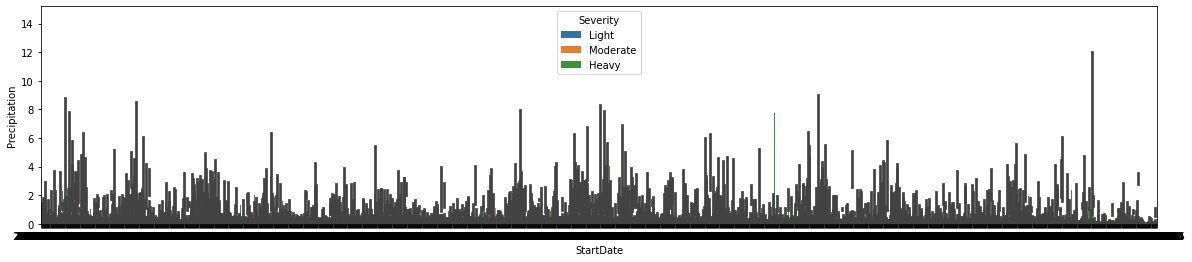

In [26]:
plt.figure(figsize=(20,4))
fig = sns.lineplot(hue="Severity", x="StartDate", y="Precipitation", data=spark_df2_filter.toPandas())
plt.show()

# Step #5 Data Analysis using PySpark.SQL

In [ ]:
# register the dataset as a temp view, so we can use sq
spark_df2.createOrReplaceTempView ("waeather_data")

In [ ]:
# see how event numbers have evolved over years
events_over_years_df = spark.sql(
        'SELECT StartYear, StartMonth, Type,Severity, COUNT(*) AS Event_Count \
        FROM waeather_data \
        GROUP BY StartMonth, StartYear, Type,Severity \
        ORDER BY StartYear, StartMonth, Event_Count')
events_over_years_df.show(5)

+---------+----------+-------------+--------+-----------+
|StartYear|StartMonth|         Type|Severity|Event_Count|
+---------+----------+-------------+--------+-----------+
|     2016|         1|        Storm|  Severe|          9|
|     2016|         1|Precipitation|      NA|         16|
|     2016|         1|         Snow|   Heavy|         18|
|     2016|         1|         Rain|   Heavy|         34|
|     2016|         1|         Cold|  Severe|         38|
+---------+----------+-------------+--------+-----------+
only showing top 5 rows



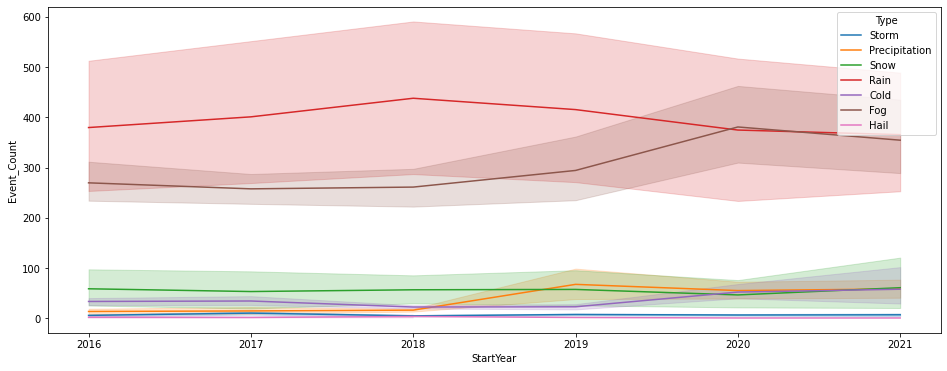

In [ ]:
plt.figure(figsize=(16,6))
fig = sns.lineplot(hue="Type", y="Event_Count", x="StartYear", data=events_over_years_df.toPandas())
plt.show()

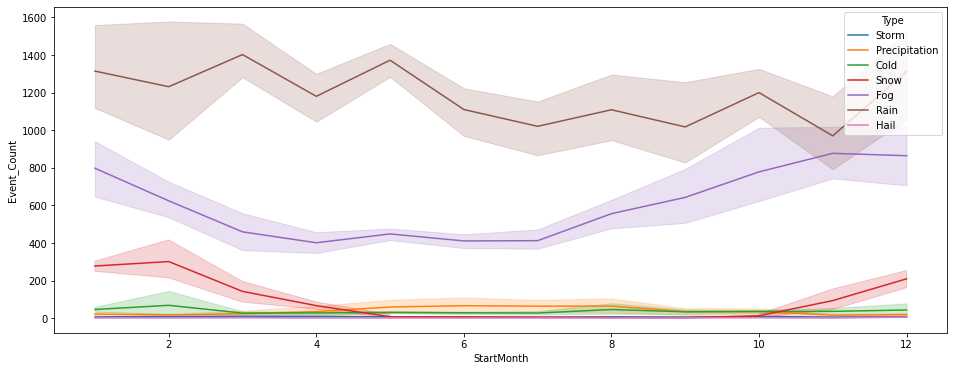

In [ ]:
plt.figure(figsize=(16,6))
fig = sns.lineplot(hue="Type", y="Event_Count", x="StartMonth", data=events_over_years_df.toPandas())
plt.show()

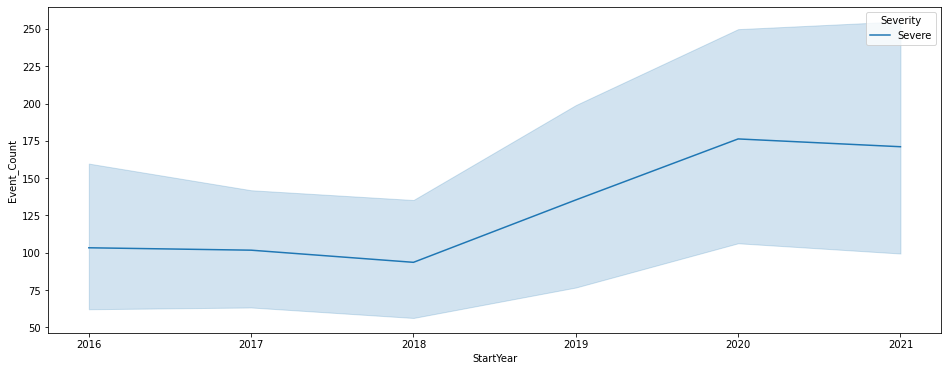

In [ ]:
plt.figure(figsize=(16,6))
events_over_years_filter_severity_df = spark.sql(
        'SELECT StartYear, StartMonth, Type,Severity, COUNT(*) AS Event_Count \
        FROM waeather_data \
        WHERE Severity = "Severe" \
        GROUP BY StartMonth, StartYear, Type,Severity \
        ORDER BY StartYear, StartMonth, Event_Count')

fig = sns.lineplot(hue="Severity", y="Event_Count", x="StartYear", data=events_over_years_filter_severity_df.toPandas())
plt.show()

# Step #6 Simple Regression with MLlib